# Dynamic Programming
Dynamic programming is both a mathematical optimization method and a computer programming method. In both contexts, it refers to simplifying a complicated problem by breaking it down into simpler sub-problems in a recursive manner.

## 1. Continuous Time: Hamilton-Jacobi-Bellman (HJB)

### Theory
Consider the optimal control problem of minimizing a cost functional:
$$
J = \int_0^T L(x(t), u(t)) \;dt + \Psi(x(T))
$$
subject to dynamics $\dot{x} = f(x, u)$.

The **Value Function** $V(x, t)$ is defined as the minimum cost-to-go from state $x$ at time $t$. The **Hamilton-Jacobi-Bellman (HJB) equation** provides a necessary condition for optimality:
$$
-\frac{\partial V}{\partial t} = \min_{u} \left[ L(x, u) + \frac{\partial V}{\partial x} f(x, u) \right]
$$
with boundary condition $V(x, T) = \Psi(x)$.

### Analytical Solutions
Analytical solutions to the HJB equation are often difficult to obtain, except for specific cases like the Linear-Quadratic Regulator (LQR). For general non-linear problems, we rely on numerical methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

### Numerical Implementation: Value Iteration
We discretize time and state space to solve the HJB equation using backward induction.

**Problem Formulation:**
- Dynamics: $\dot{x} = u$ (Simple motion)
- Cost: $L(x, u) = 35u^2 + 16x$ (Penalize control effort and state)
- Horizon: $T = 1.0$
- Constraints: $x \in [0, 20]$, $u \in [-5, 5]$

In [2]:
class HJBSolver:
    def __init__(self, x_grid, u_grid, dt, T, dynamics, running_cost, terminal_cost=None):
        self.x_grid = x_grid
        self.u_grid = u_grid
        self.dt = dt
        self.T = T
        self.N_steps = int(T / dt)
        self.dynamics = dynamics
        self.running_cost = running_cost
        
        # Initialize Value Function Table V(x, t)
        # Shape: (num_states, num_time_steps + 1)
        self.V = np.zeros((len(x_grid), self.N_steps + 1))
        self.policy = np.zeros((len(x_grid), self.N_steps))
        
        # Set terminal cost V(x, T)
        if terminal_cost:
            self.V[:, -1] = terminal_cost(x_grid)
            
    def solve(self):
        dx = self.x_grid[1] - self.x_grid[0]
        x_min, x_max = self.x_grid[0], self.x_grid[-1]
        
        # Backward Induction
        for t in range(self.N_steps - 1, -1, -1):
            for i, x in enumerate(self.x_grid):
                costs = []
                valid_u = []
                
                for u in self.u_grid:
                    # Dynamics Update (Euler Integration)
                    x_next = x + self.dynamics(x, u) * self.dt
                    
                    # Check boundaries
                    if x_next < x_min or x_next > x_max:
                        continue
                        
                    # Find nearest neighbor index for x_next
                    # (Linear interpolation would be more accurate, but NN is simpler for demo)
                    j_next = int(round((x_next - x_min) / dx))
                    j_next = np.clip(j_next, 0, len(self.x_grid) - 1)
                    
                    # Cost-to-go = Running Cost + Value at next state
                    cost = self.running_cost(x, u) * self.dt + self.V[j_next, t + 1]
                    costs.append(cost)
                    valid_u.append(u)
                
                # Minimization
                if costs:
                    min_idx = np.argmin(costs)
                    self.V[i, t] = costs[min_idx]
                    self.policy[i, t] = valid_u[min_idx]
                else:
                    # If no valid control moves, assign high cost (soft constraint)
                    self.V[i, t] = float('inf')

        return self.V, self.policy

In [17]:
# Define Problem Parameters
x_vals = np.arange(0, 20.1, 0.1)
u_vals = np.arange(-5, 5.1, 0.5)
dt = 0.01
T = 1.0

def dynamics(x, u):
    return u

def cost_func(x, u):
    return 35 * u**2 + 16 * x

# Solve
solver = HJBSolver(x_vals, u_vals, dt, T, dynamics, cost_func)
V, policy = solver.solve()

### Visualization of HJB Results

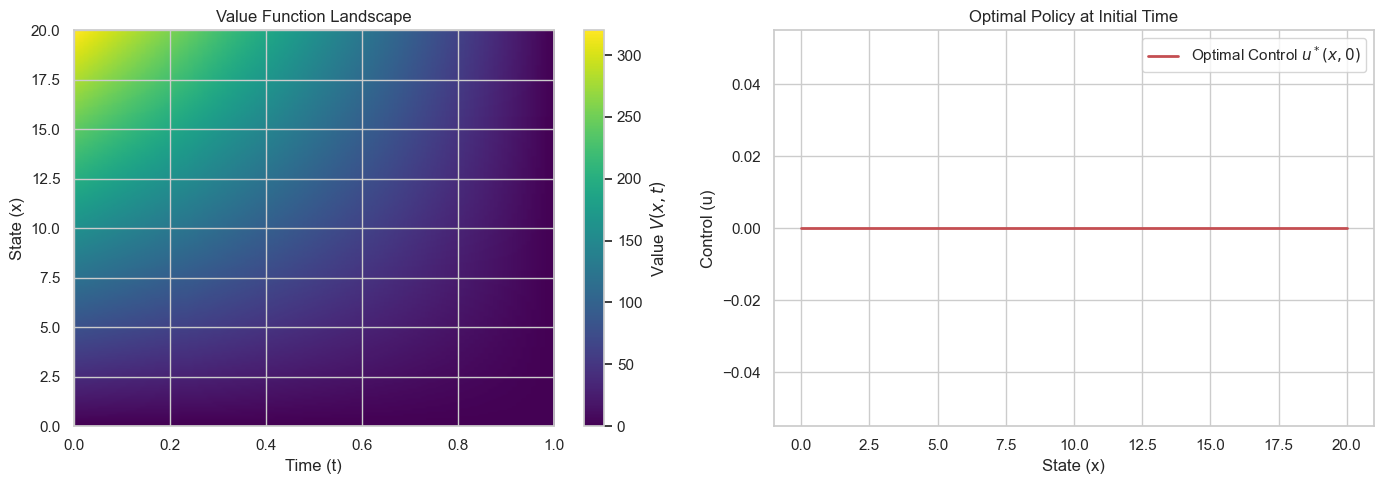

In [18]:
plt.figure(figsize=(14, 5))

# Plot Value Function heatmap
plt.subplot(1, 2, 1)
time_steps = np.linspace(0, T, V.shape[1])
plt.imshow(V, aspect='auto', cmap='viridis', origin='lower', 
           extent=[0, T, x_vals[0], x_vals[-1]])
plt.colorbar(label='Value $V(x,t)$')
plt.xlabel('Time (t)')
plt.ylabel('State (x)')
plt.title('Value Function Landscape')

# Plot Optimal Policy at t=0
plt.subplot(1, 2, 2)
plt.plot(x_vals, policy[:, 0], label='Optimal Control $u^*(x, 0)$', color='r', linewidth=2)
plt.xlabel('State (x)')
plt.ylabel('Control (u)')
plt.title('Optimal Policy at Initial Time')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Discrete DP: Shortest Path in a Graph

Dynamic programming is widely used on graphs, for example, to find the shortest path. We use the **Principle of Optimality**: the subpath of an optimal path is itself optimal.

We will solve for the shortest path from **Start (S)** to **Target (T)** in a Weighted Directed Acyclic Graph (DAG) using backward recursion.

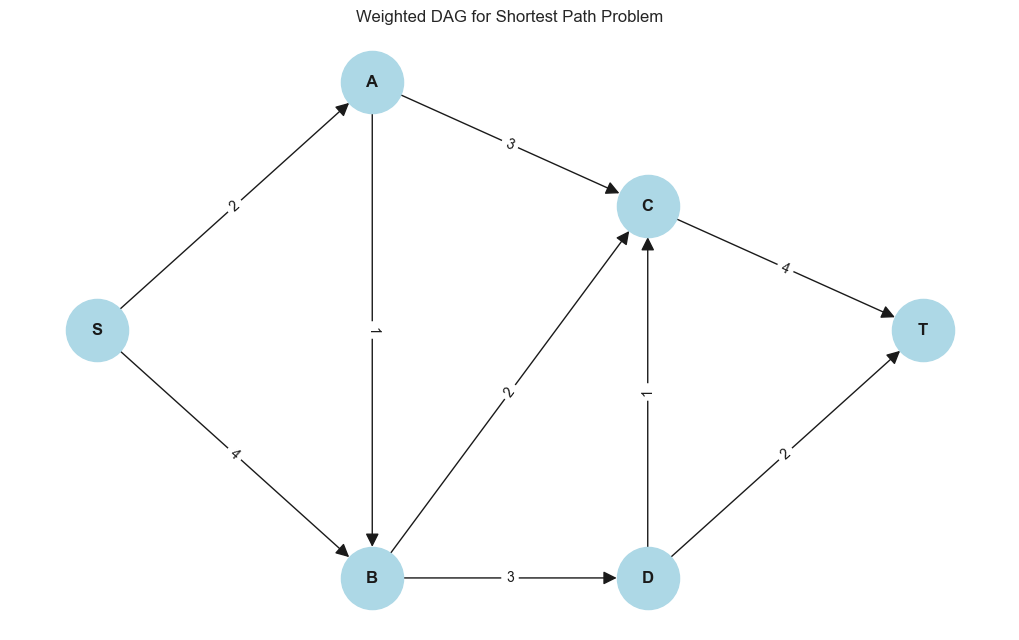

In [19]:
import networkx as nx

# Create a Directed Graph
G = nx.DiGraph()

# Define Edges with Weights (Cost)
edges = [
    ('S', 'A', 2), ('S', 'B', 4),
    ('A', 'C', 3), ('A', 'B', 1),
    ('B', 'C', 2), ('B', 'D', 3),
    ('C', 'T', 4),
    ('D', 'T', 2), ('D', 'C', 1)
]
G.add_weighted_edges_from(edges)

# Visualize the graph
pos = {'S': (0, 1), 'A': (1, 2), 'B': (1, 0), 'C': (2, 1.5), 'D': (2, 0), 'T': (3, 1)}
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=12, font_weight='bold', arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Weighted DAG for Shortest Path Problem")
plt.show()

### Implementation: Backward Recursion
We calculate $J(n)$, the minimum cost to reach node $T$ from node $n$.
- $J(T) = 0$
- $J(n) = \min_{m \in \text{neighbors}(n)} \{ cost(n, m) + J(m) \}$

In [20]:
# Topological sort allows us to process nodes in backward order (from target to source)
try:
    topo_order = list(nx.topological_sort(G))
except nx.NetworkXUnfeasible:
    print("Graph contains cycles, cannot use topological sort for simple iteration. Using Bellman-Ford or Dijkstra logic instead.")
    topo_order = list(G.nodes())

# Initialize Costs
J = {node: float('inf') for node in G.nodes()}
J['T'] = 0  # Cost to reach Target from Target is 0
optimal_action = {node: None for node in G.nodes()}

# Iterate backwards
# (Note: Topological sort gives an ordering S -> T. We reverse it to go T -> S)
for u in reversed(topo_order):
    if u == 'T':
        continue
    
    # Examine all outgoing edges
    possible_costs = []
    for v in G.successors(u):
        weight = G[u][v]['weight']
        cost = weight + J[v]
        possible_costs.append((cost, v))
    
    if possible_costs:
        min_cost, best_next_node = min(possible_costs, key=lambda x: x[0])
        J[u] = min_cost
        optimal_action[u] = best_next_node

print("Minimum Costs to reach T:")
for node, cost in J.items():
    print(f"J({node}) = {cost}")

# Reconstruct Path
path = ['S']
curr = 'S'
while curr != 'T' and curr is not None:
    curr = optimal_action[curr]
    if curr:
        path.append(curr)

print(f"\nOptimal Path: {' -> '.join(path)}")

Minimum Costs to reach T:
J(S) = 8
J(A) = 6
J(B) = 5
J(C) = 4
J(D) = 2
J(T) = 0

Optimal Path: S -> A -> B -> D -> T
